### Import bibliotek

In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from simpful import *

### Lista kolumn do wykorzystania w analizie

In [297]:
# Kolumny uzyskane na podstawie analizy korelacji oraz ważności cech (XGBoostClassifier)
final_columns = [
    'B365CH',
    'B365CA',
    'MaxCH',
    'MaxCA',
    'AvgCH',
    'AvgCA',
    'B365H',
    'PSCH',
    'PSCA',
    'VCCH',
    'VCCA',
    'WHCH',
    'WHCA',
    'WHH',
    'VCH',
    'MaxH',
    'diff_team_score_xG_sum_last_15_matches',
    'diff_team_score_xG_sum_last_13_matches',
    'diff_team_shots_avg_last_15_matches',
    'diff_team_attacking_third_touches_sum_last_13_matches',
    'diff_team_shots_on_target_avg_last_13_matches',
    'diff_team_penalty_area_touches_avg_last_13_matches',
    'diff_team_penalty_area_touches_avg_last_15_matches',
    'diff_team_penalty_area_touches_sum_last_7_matches',
    'diff_team_momentum_sum_avg_last_11_matches',
    'diff_team_shot_creating_actions_avg_last_15_matches',
    'diff_team_score_xG_avg_last_7_matches',
    'diff_team_momentum_count_sum_last_9_matches'
]

### Zmienne lingwistyczne

In [298]:
# Definicja zmiennej lingwistycznej na podstawie kwantyli
def create_linguistic_variable(data: pd.Series, percentiles: tuple[float] = (0.25, 0.5, 0.75), concept: str = "Concept") -> LinguisticVariable:
    # Opis statystyczny danych
    description = data.describe(percentiles=percentiles)
    
    # Uniwersum zmiennej lingwistycznej
    universe_of_discourse = [description["min"], description["max"]]
    
    # Nazwy kwantyli
    percentiles_names = [f"{int(q*100)}%" for q in percentiles]
    
    # Zbiory rozmyte - niski, średni, wysoki
    LOW_TERM = FuzzySet(points=[[description["min"], 1], [description[percentiles_names[0]], 1], [description[percentiles_names[1]], 0]], term="low")
    MEDIUM_TERM = FuzzySet(points=[[description[percentiles_names[0]], 0], [description[percentiles_names[1]], 1], [description[percentiles_names[2]], 0]], term="medium")
    HIGH_TERM = FuzzySet(points=[[description[percentiles_names[1]], 0], [description[percentiles_names[2]], 1], [description["max"], 1]], term="high")
    
    # Zmienna lingwistyczna
    return LinguisticVariable([LOW_TERM, MEDIUM_TERM, HIGH_TERM], concept=concept, universe_of_discourse=universe_of_discourse)

### Klasyfikator rozmyty

In [299]:
class FuzzyClassifier(BaseEstimator):
    def __init__(self):
        self.model = FuzzySystem()
        self.linguistic_variables = {}
        self.output_linguistic_variable = None
        
        self._init_output_linguistic_variable()
            
    def init_linguistic_variables(self, X: pd.DataFrame, percentiles: tuple[float] = (0.25, 0.5, 0.75)):
        for column in X.columns:
            self.linguistic_variables[column] = create_linguistic_variable(X[column], percentiles=percentiles, concept=column)
            self.model.add_linguistic_variable(column, self.linguistic_variables[column])
        
    def add_rules(self, rules: list[str]):
        self.model.add_rules(rules)
    
    def predict(self, X: pd.DataFrame, y_true: np.array = None):
        predictions = []
        for _, row in X.iterrows():
            for column, value in row.items():
                self.model.set_variable(column, value)
            result = self.model.inference()["Match_Result"]
            print(result, y_true[_]) if y_true is not None else None
            
            if result < 1:
                predictions.append(-1)
            elif result < 2:
                predictions.append(0)
            else:
                predictions.append(1)
        
        return np.array(predictions)
    
    def calculate_metrics(self, y_true: np.array, y_pred: np.array):
        return {
            "accuracy": accuracy_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred, average="macro"),
            "recall": recall_score(y_true, y_pred, average="macro"),
            "f1": f1_score(y_true, y_pred, average="macro")
        }
    
    def plot_classification_report(self, y_true: np.array, y_pred: np.array):
        # Raport klasyfikacji
        report = classification_report(y_true, y_pred, output_dict=True)

        # Wizualizacja raportu w formie heatmapy
        sns.heatmap(pd.DataFrame(report).T, annot=True, cmap="coolwarm")
        
    def _init_output_linguistic_variable(self):
        LOSS = FuzzySet(points=[[0, 0], [0.5, 1], [1, 0]], term="loss")
        DRAW = FuzzySet(points=[[1, 0], [1.5, 1], [2, 0]], term="draw")
        WIN = FuzzySet(points=[[2, 0], [2.5, 1], [3, 0]], term="win")
        OUTPUT_MATCH_RESULT = LinguisticVariable([LOSS, DRAW, WIN], concept="Match_Result", universe_of_discourse=[0, 3])
        
        self.output_linguistic_variable = OUTPUT_MATCH_RESULT
        self.model.add_linguistic_variable("Match_Result", OUTPUT_MATCH_RESULT)

### Wczytanie danych

In [300]:
league = 'premier_league' # dostępne opcje: `premier_league`, `laliga`, `bundesliga`, `serie_a`
train_data = pd.read_pickle(f'data/{league}/train_data.pkl')
test_data = pd.read_pickle(f'data/{league}/test_data.pkl')

### Inicjalizacja klasyfikatora rozmytego

In [301]:
fuzzy_classifier = FuzzyClassifier()
fuzzy_classifier.init_linguistic_variables(train_data[final_columns])

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.12.0 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 https://github.com/aresio/simpful



### Definicja reguł

In [302]:
rules = [
    "IF (B365CH IS high) AND (diff_team_score_xG_sum_last_15_matches IS low) AND (diff_team_shots_avg_last_15_matches IS low) AND (diff_team_penalty_area_touches_avg_last_15_matches IS low) THEN Match_Result IS loss",
    "IF (AvgCH IS high) AND (diff_team_shots_on_target_avg_last_13_matches IS low) AND (diff_team_momentum_sum_avg_last_11_matches IS low) AND (diff_team_score_xG_avg_last_7_matches IS low) THEN Match_Result IS loss",
    "IF (MaxCH IS high) AND (diff_team_score_xG_sum_last_13_matches IS low) AND (diff_team_shot_creating_actions_avg_last_15_matches IS low) THEN Match_Result IS loss",
    "IF (WHCH IS high) AND (diff_team_shots_on_target_avg_last_13_matches IS low) AND (diff_team_penalty_area_touches_avg_last_15_matches IS low) THEN Match_Result IS loss",
    "IF (VCCH IS high) AND (diff_team_momentum_sum_avg_last_11_matches IS low) AND (diff_team_shot_creating_actions_avg_last_15_matches IS low) THEN Match_Result IS loss",
    "IF (B365CA IS low) AND (diff_team_shots_on_target_avg_last_13_matches IS high) AND (diff_team_score_xG_sum_last_15_matches IS high) AND (diff_team_momentum_sum_avg_last_11_matches IS high) THEN Match_Result IS win",
    "IF (PSCH IS high) AND (diff_team_shots_avg_last_15_matches IS high) AND (diff_team_penalty_area_touches_sum_last_7_matches IS high) THEN Match_Result IS win",
    "IF (MaxCA IS low) AND (diff_team_score_xG_avg_last_7_matches IS high) AND (diff_team_shot_creating_actions_avg_last_15_matches IS high) THEN Match_Result IS win",
    "IF (WHCA IS low) AND (diff_team_momentum_sum_avg_last_11_matches IS high) AND (diff_team_score_xG_avg_last_7_matches IS high) THEN Match_Result IS win",
    "IF (VCCA IS low) AND (diff_team_shots_avg_last_15_matches IS high) AND (diff_team_shot_creating_actions_avg_last_15_matches IS high) THEN Match_Result IS win",
    "IF (diff_team_score_xG_sum_last_15_matches IS low) AND (B365CH IS low) THEN Match_Result IS draw",
    "IF (diff_team_shots_avg_last_15_matches IS low) AND (MaxCH IS low) THEN Match_Result IS draw",
    "IF (diff_team_shots_on_target_avg_last_13_matches IS low) AND (AvgCH IS low) THEN Match_Result IS draw",
    "IF (diff_team_penalty_area_touches_sum_last_7_matches IS low) AND (PSCH IS low) THEN Match_Result IS draw",
    "IF (diff_team_shot_creating_actions_avg_last_15_matches IS low) AND (MaxCA IS high) THEN Match_Result IS draw",
    "IF (diff_team_penalty_area_touches_avg_last_13_matches IS low) AND (VCH IS low) THEN Match_Result IS draw",
    "IF (diff_team_score_xG_sum_last_13_matches IS low) AND (diff_team_penalty_area_touches_avg_last_13_matches IS low) AND (diff_team_shots_on_target_avg_last_13_matches IS low) THEN Match_Result IS loss",
    "IF (B365CH IS high) AND (diff_team_score_xG_avg_last_7_matches IS low) AND (diff_team_shots_on_target_avg_last_13_matches IS low) AND (diff_team_momentum_count_sum_last_9_matches IS low) THEN Match_Result IS loss",
    "IF (diff_team_penalty_area_touches_avg_last_15_matches IS low) AND (diff_team_shots_avg_last_15_matches IS low) AND (diff_team_score_xG_sum_last_13_matches IS low) THEN Match_Result IS loss",
    "IF (VCH IS high) AND (diff_team_shot_creating_actions_avg_last_15_matches IS low) AND (diff_team_score_xG_avg_last_7_matches IS low) THEN Match_Result IS loss",
    "IF (PSCH IS high) AND (diff_team_shots_avg_last_15_matches IS high) AND (diff_team_score_xG_sum_last_15_matches IS high) THEN Match_Result IS win",
    "IF (MaxCA IS low) AND (diff_team_shots_on_target_avg_last_13_matches IS high) AND (diff_team_penalty_area_touches_sum_last_7_matches IS high) THEN Match_Result IS win",
    "IF (AvgCA IS low) AND (diff_team_shot_creating_actions_avg_last_15_matches IS high) AND (diff_team_momentum_sum_avg_last_11_matches IS high) THEN Match_Result IS win",
    "IF (VCCA IS low) AND (diff_team_momentum_count_sum_last_9_matches IS high) AND (diff_team_score_xG_avg_last_7_matches IS high) THEN Match_Result IS win",
    "IF (VCCH IS low) AND (diff_team_shots_avg_last_15_matches IS high) AND (diff_team_penalty_area_touches_sum_last_7_matches IS high) THEN Match_Result IS win",
    "IF (diff_team_shots_on_target_avg_last_13_matches IS low) AND (B365CH IS low) THEN Match_Result IS draw",
    "IF (diff_team_score_xG_sum_last_15_matches IS low) AND (MaxCH IS low) THEN Match_Result IS draw",
    "IF (diff_team_momentum_sum_avg_last_11_matches IS low) AND (PSCH IS low) THEN Match_Result IS draw",
    "IF (diff_team_penalty_area_touches_sum_last_7_matches IS low) AND (VCH IS low) THEN Match_Result IS draw",
    "IF (diff_team_shot_creating_actions_avg_last_15_matches IS low) AND (VCCA IS low) THEN Match_Result IS draw"
]

fuzzy_classifier.add_rules(rules)

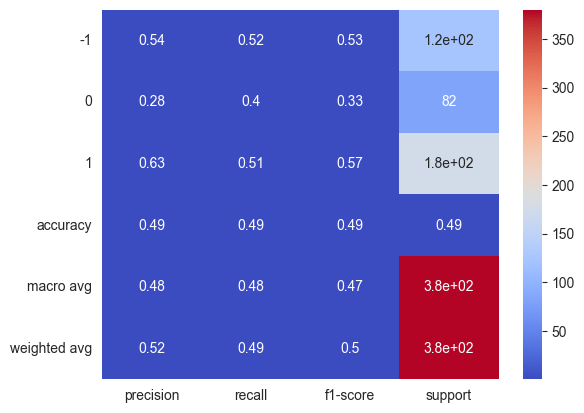

In [303]:
fuzzy_classifier.plot_classification_report(test_data["match_outcome_encoded"], fuzzy_classifier.predict(test_data[final_columns]))